In [1]:
import os
import sqlite3
import pandas as pd
import torch
import json
from transformers import RobertaTokenizer
from modules.models import CodeBertJS,CodeT5
from modules.datasets import CodeBertDataset, CodeT5Dataset
from modules.metrics import CodeRouge
from modules.filters import add_labels
from torch.utils.data import DataLoader

SQLITE_PATH = 'commitpack-datasets.db' if os.path.exists('commitpack-datasets.db') else '/content/drive/MyDrive/Thesis/commitpack-datasets.db'
CPKT_PATH = input('Paste cpkt path: ')
if not os.path.exists(CPKT_PATH):
    raise FileNotFoundError(f"{CPKT_PATH} does not exist.")
os.environ['CPKT_PATH'] = CPKT_PATH
MODEL_NAME = CPKT_PATH.split('/')[-1].split('.')[0].split('_')[0]
os.environ['MODEL_NAME'] = MODEL_NAME
VERSION = CPKT_PATH.split('/')[-1].split('.')[0].split('_')[-1][-1]
os.environ['VERSION'] = VERSION
METRICS_PATH = 'metrics' if os.path.exists('metrics') else '/content/drive/MyDrive/Thesis/metrics'
os.environ['METRICS_PATH'] = METRICS_PATH
HF_DIR = 'Salesforce/codet5-small' if MODEL_NAME == 'CodeT5JS' else 'microsoft/codebert-base-mlm'
MAX_LENGTH = 420 if MODEL_NAME == 'CodeT5JS' else 350
DB_TABLE = "commitpackft_classified_test"
con = sqlite3.connect(SQLITE_PATH)
DEBUG = True if int(input('Debug Run (1,0): ')) == 1 else False

# Bug Types Distribution

In [2]:
with open('bug-type-dist-query_test.sql', 'r')as f:
    distQuery = f.read()
f.close()
info_df = pd.read_sql_query(distQuery, con)
info_df

,count(*),bug_type
0,25,mobile
1,723,general
2,761,network-security
3,772,ui-ux
4,1063,compatibility-performance
5,1118,functionality


# Load Model And Data

In [3]:
query = f"select * from {DB_TABLE}"
ds_df = pd.read_sql_query(query, con)
ds_df['class_labels'] = ds_df['bug_type'].apply(lambda bT: add_labels(bT))

if DEBUG:
    ds_df = ds_df.iloc[:10]

ds_df.head()

,index,commit,old_file,new_file,old_contents,new_contents,subject,message,lang,license,repos,processed_message,is_bug,bug_type,class_labels
0,48968,4d949a2bc8f628dcc66ee62161ae3680b21766d0,bin/pep-proxy.js,bin/pep-proxy.js,#!/usr/bin/env node\n\nvar proxy = require('.....,#!/usr/bin/env node\n\nvar proxy = require('.....,FIX Move the module definition to the top of t...,FIX Move the module definition to the top of t...,JavaScript,agpl-3.0,"telefonicaid/fiware-pep-steelskin,telefonicaid...",fix move modul definit top function,1,functionality,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
1,21631,58c6907562ca3d4e943dfed56e795ae0a9cde762,lib/cache/lib/processUndefined.js,lib/cache/lib/processUndefined.js,"export default (doc, fields) => {\n fields....","export default (doc, fields) => {\n fields....",Fix for undefined on nested fields,Fix for undefined on nested fields\n,JavaScript,mit,cult-of-coders/redis-oplog,fix undefin nest field,1,ui-ux,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,38478,54bc7736bc5d3381a48eebba476f0933884899c6,lib/errorMessages.js,lib/errorMessages.js,"""use strict"";\n\nmodule.exports = {\n loadU...","""use strict"";\n\nmodule.exports = {\n loadU...",Clean up some error message.,Clean up some error message.\n,JavaScript,mit,YuzuJS/storeit,clean error messag,1,general,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,45690,2f3f141e1196eaa39ade102d3795cd189f57828f,src/IconMenu/IconMenu.js,src/IconMenu/IconMenu.js,import React from 'react'\nimport PropTypes fr...,import React from 'react'\nimport PropTypes fr...,Rename prop name => iconName,refactor(components): Rename prop name => icon...,JavaScript,mit,"dimik/react-material-web-components,dimik/reac...",refactorcompon renam prop name = iconnam,1,general,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4,38421,bc2e4d8ebd609461c4abc63db480ae1aa5558ff7,ghost/admin/controllers/editor/new.js,ghost/admin/controllers/editor/new.js,import EditorControllerMixin from 'ghost/mixin...,import EditorControllerMixin from 'ghost/mixin...,Fix warning about transitionTo being deprecated,Fix warning about transitionTo being deprecated\n,JavaScript,mit,"TryGhost/Ghost,TryGhost/Ghost,TryGhost/Ghost",fix warn transitionto deprec,1,general,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [4]:
if MODEL_NAME == 'CodeT5JS':
    model = CodeT5.load_from_checkpoint(CPKT_PATH)
elif 'CodeBertJS' in MODEL_NAME:
    model = CodeBertJS.load_from_checkpoint(CPKT_PATH)
    
model.model.to('cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32100, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [5]:
encoded_samples = model.tokenizer(
    ds_df['old_contents'].tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

encoded_labels = model.tokenizer(
    ds_df['new_contents'].tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

labels = torch.tensor(ds_df['class_labels'].tolist())

In [6]:
if MODEL_NAME == 'CodeT5JS':
    torch_ds = CodeT5Dataset(encodings=encoded_samples, decodings=encoded_labels, class_labels=labels)
elif 'CodeBertJS' in MODEL_NAME:
    torch_ds = CodeBertDataset(encoded_samples, encoded_labels.input_ids)
loader = DataLoader(torch_ds, batch_size=1)

# Run Test Script

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/disras/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

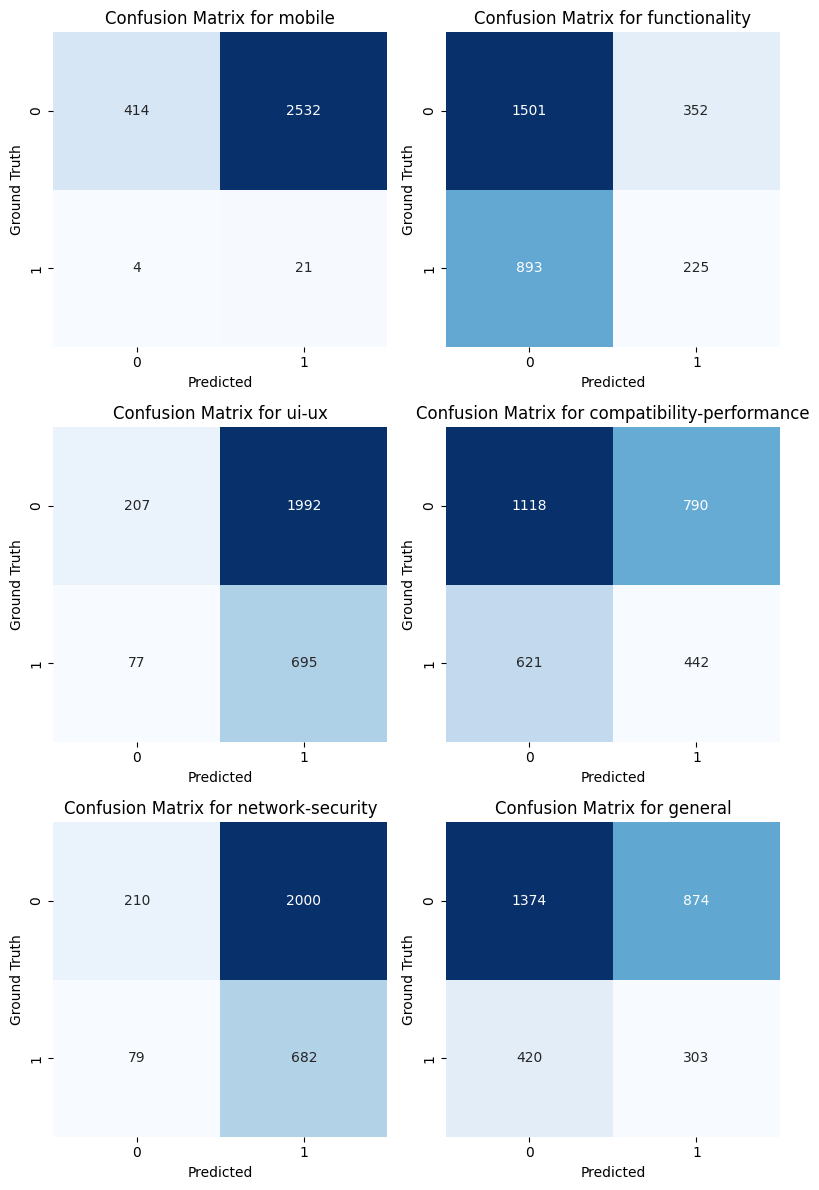

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1660238802433014     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1660238802433014}]

In [ ]:
from pytorch_lightning import Trainer
trainer = Trainer()

trainer.test(model=model, dataloaders=loader)

# Evaluation & Metrics

In [10]:
rouge = CodeRouge(['rouge7','rouge8','rouge9','rougeL','rougeLsum'])

rouge.compute(predictions=model.generated_codes, references=ds_df['new_contents'].tolist())
rouge.calc_averages()

avgs_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/rouge.json"
all_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/avg_rouge.csv"
with open(avgs_path, 'a') as f:
    json.dump(rouge.avgs, f, indent=4)

all_scores = []
for r in rouge.rouge_types:
    all_scores += rouge.rouge_type_to_list(r)

metrics_df = pd.DataFrame(all_scores)

for m in ['precision','recall','fmeasure']:
    metrics_df[m] = round(metrics_df[m], 3)
metrics_df.to_csv(all_path, index=False)

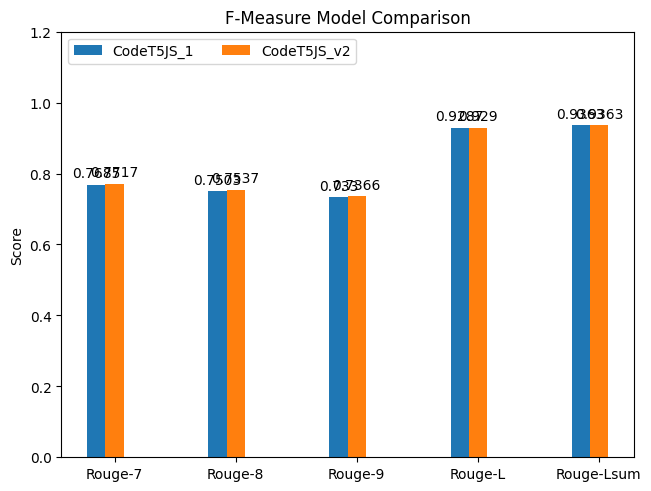

In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)
    

plot_data = {
    f"{MODEL_NAME}_{VERSION}": (round(codebert_avgs['avg_rouge7'].fmeasure, 5), round(codebert_avgs['avg_rouge8'].fmeasure, 5), round(codebert_avgs['avg_rouge9'].fmeasure, 5), round(codebert_avgs['avg_rougeL'].fmeasure, 5), round(codebert_avgs['avg_rougeLsum'].fmeasure, 5)),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}

metric_types = ('Rouge-7', 'Rouge-8','Rouge-9', 'Rouge-L', 'Rouge-Lsum')
x = np.arange(len(metric_types))
width = 0.15
multiplier = 0

fix, ax = plt.subplots(layout='constrained')


for model, values in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('F-Measure Model Comparison')
ax.set_xticks(x + width, metric_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
plt.show()

<Axes: title={'center': 'F-Measure Model Comparison'}, ylabel='Score'>

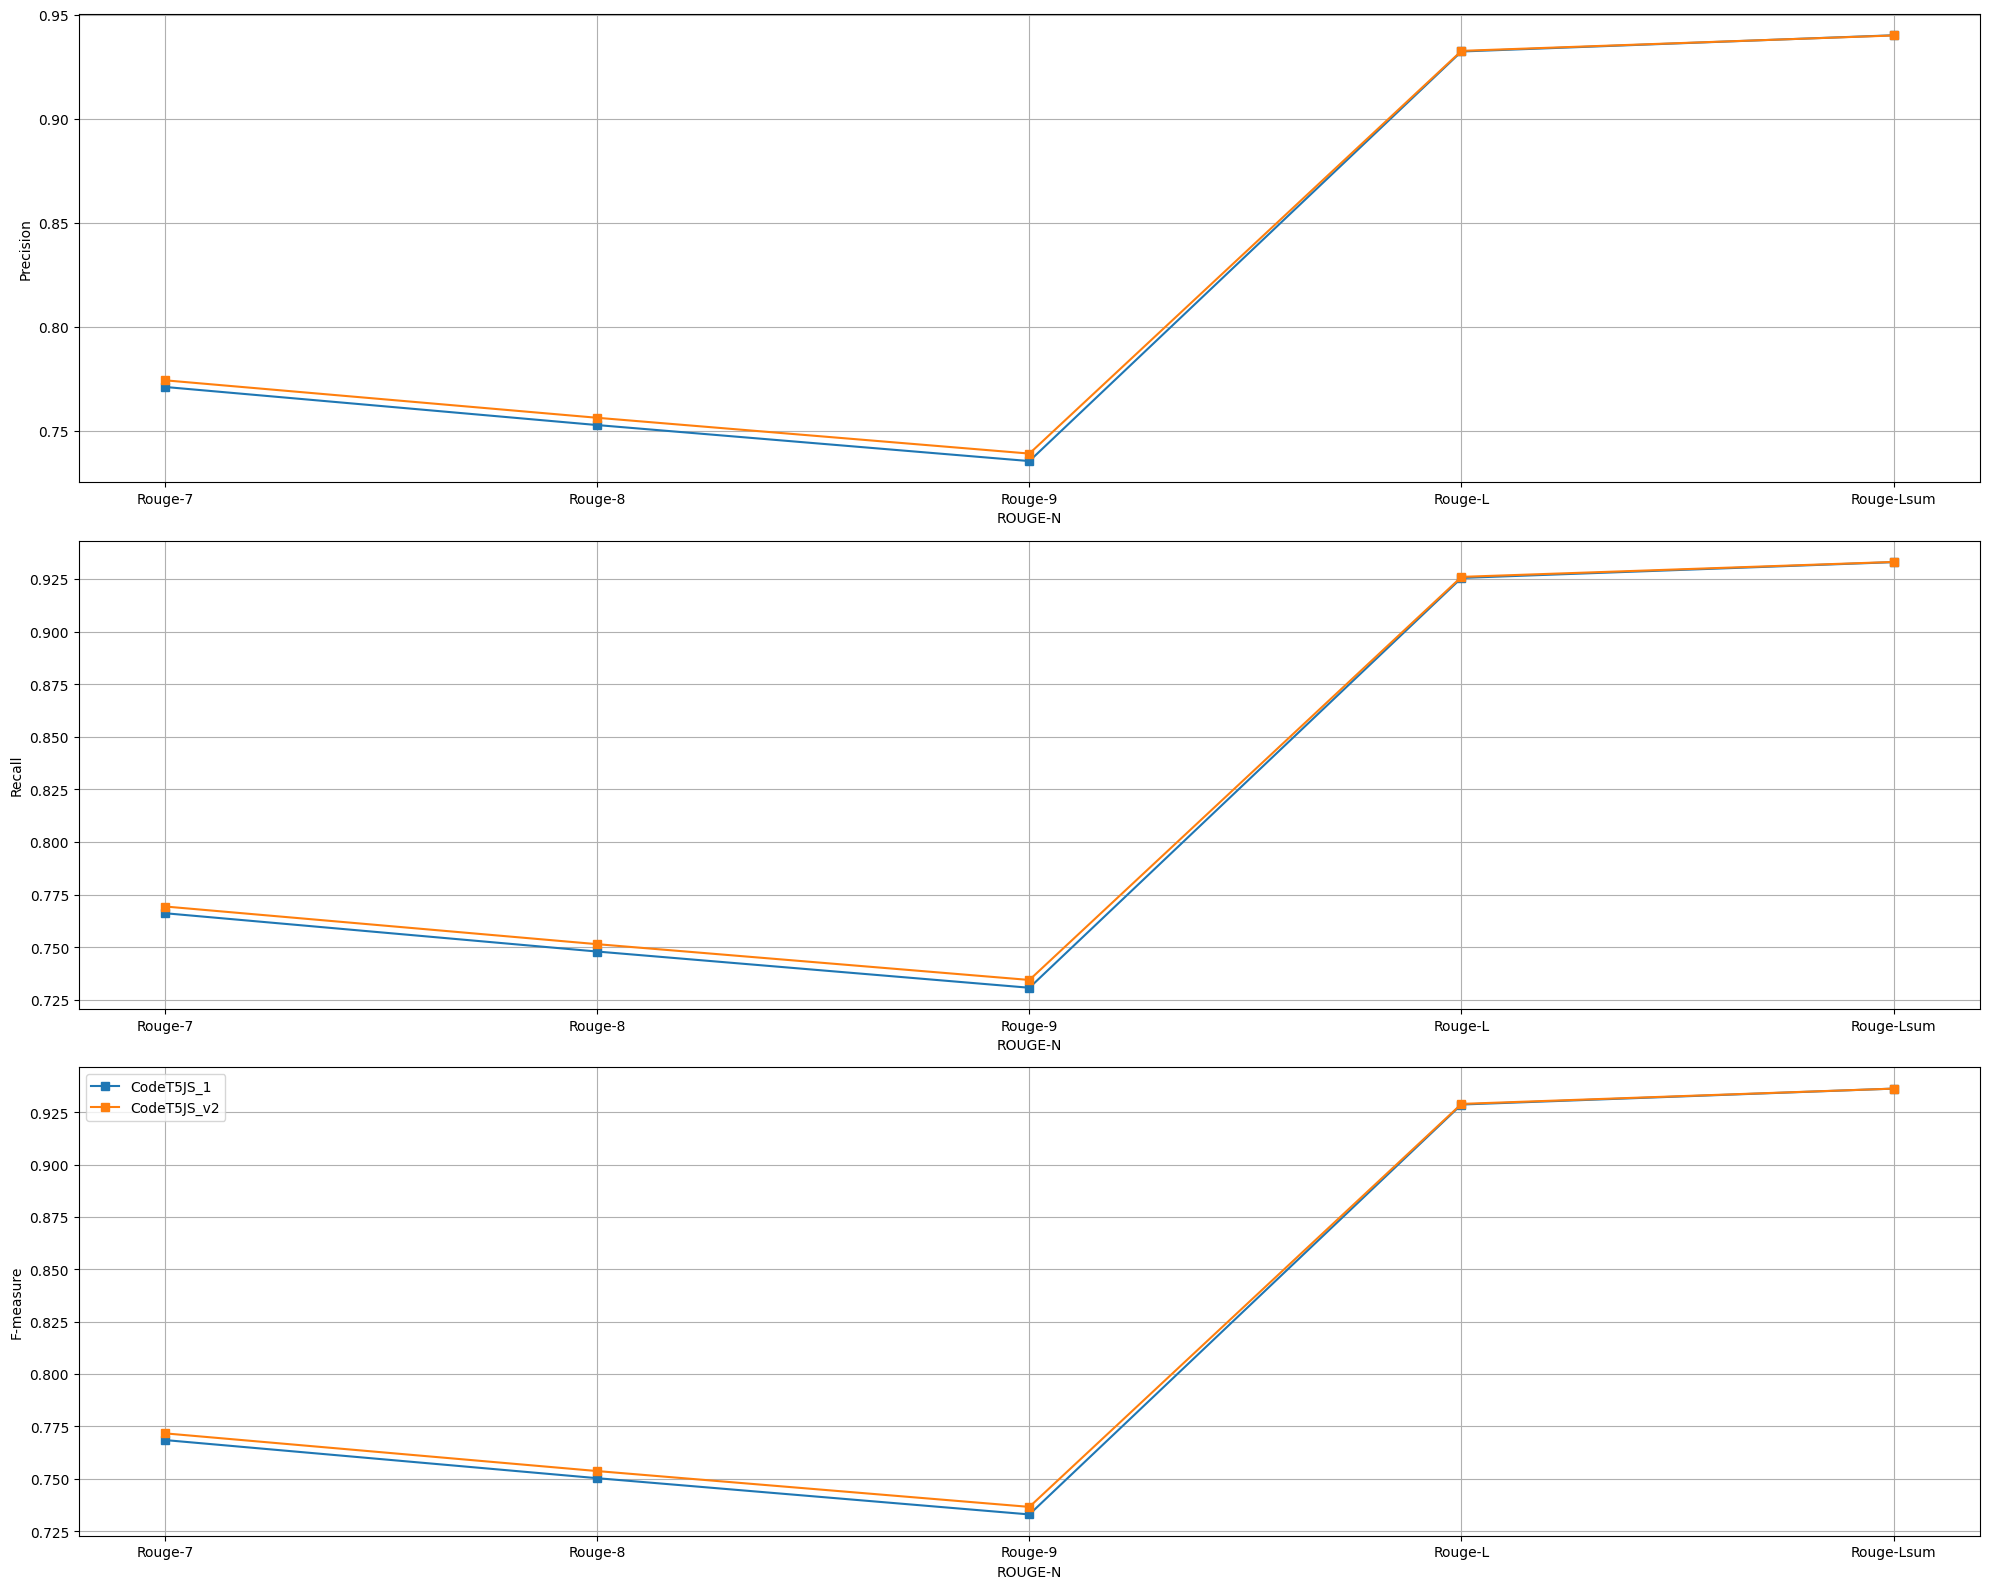

In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs  # Assuming rouge is a library/function that provides average scores

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)

# Define metric types (assuming same metrics for both models)
metric_types = ('Rouge-7', 'Rouge-8', 'Rouge-9', 'Rouge-L', 'Rouge-Lsum')

# Create a figure with 3 rows (subplots) and 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16))

# Data dictionaries for each metric (assuming data structure from rouge)
precision_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].precision, codebert_avgs['avg_rouge8'].precision, codebert_avgs['avg_rouge9'].precision, codebert_avgs['avg_rougeL'].precision, codebert_avgs['avg_rougeLsum'].precision),
    comparison_model: (codet5_avgs['avg_rouge7'][0], codet5_avgs['avg_rouge8'][0], codet5_avgs['avg_rouge9'][0], codet5_avgs['avg_rougeL'][0], codet5_avgs['avg_rougeLsum'][0]),
}
recall_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].recall, codebert_avgs['avg_rouge8'].recall, codebert_avgs['avg_rouge9'].recall, codebert_avgs['avg_rougeL'].recall, codebert_avgs['avg_rougeLsum'].recall),
    comparison_model: (codet5_avgs['avg_rouge7'][1], codet5_avgs['avg_rouge8'][1], codet5_avgs['avg_rouge9'][1], codet5_avgs['avg_rougeL'][1], codet5_avgs['avg_rougeLsum'][1]),
}
f1_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].fmeasure, codebert_avgs['avg_rouge8'].fmeasure, codebert_avgs['avg_rouge9'].fmeasure, codebert_avgs['avg_rougeL'].fmeasure, codebert_avgs['avg_rougeLsum'].fmeasure),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}


# Plot Precision (ax1)
for model, precision in precision_data.items():
    ax1.plot(metric_types, precision, label=model, marker='s')  # 's' for square marker
ax1.set_xlabel('ROUGE-N')
ax1.set_ylabel('Precision')
ax1.grid(True)

# Plot Recall (ax2)
for model, recall in recall_data.items():
    ax2.plot(metric_types, recall, label=model, marker='s')  # 'o' for circle marker
ax2.set_xlabel('ROUGE-N')
ax2.set_ylabel('Recall')
ax2.grid(True)

# Plot F1 Score (ax3)
for model, f1 in f1_data.items():
    ax3.plot(metric_types, f1, label=model, marker='s')
ax3.set_xlabel('ROUGE-N')
ax3.set_ylabel('F-measure')
ax3.grid(True)

plt.legend(loc='upper left')
plt.tight_layout()

# Save the entire figure as a single PNG
plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
ax